## 설정 
#### 
- 폰트는 개인 설정에 맞게 바꿀 것                           
- 마지막 옵션은 최대 표시량을 바꿔주는 옵션이므로 필요에 따라 사용할 것

In [1]:
import os
import sys
import urllib.request
import json

In [2]:
import numpy as np
import pandas as pd
import copy

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/NanumGothic.ttf").get_name()
rc('font', family=font_name)

In [ ]:
 # pd.set_option('display.max_columns', 100)

## 준비작업
#### 
- cate_5_list.csv 파일은 카테고리별 검색 키워드를 작성해둔 파일
- 키워드는 최대한 다른 키워드와 겹치지 않는 선에서 선정하였으며
    - ex. "노니"의 경우 "노니비누"와 겹치지 않게 노니원액, 노니분말 등으로 선정
- 기본적으로는 카테고리 이름에서 벗어나지 않도록 함
- 부르는 방법이 다양한 경우 모두 포함함 
    - ex. "Qoq10"의 경우 코큐텐, 코엔자임큐텐, 코엔자임Q10 등을 모두 선정함
- 기타영양제 처럼 키워드가 모호한 경우 제외함 (3개가 빠짐)

In [4]:
search_word = pd.read_csv("data/cate_5_list.csv", encoding = "utf-8-sig", index_col = "index")

In [5]:
search_word = search_word[search_word["values"].isna() == False]

In [6]:
search_word.head()

keys                   values
index                                   
0       프로바이오틱스       유산균, 프로바이오틱스, 생유산균
1      기타다이어트식품                  다이어트쉐이크
2          뷰티푸드                      버닝티
3         헬스보충제  단백질보충제, 헬스보충제, 게이너, 프로틴
4           곤약쌀                 곤약쌀, 곤약미

#### 네이버 API 사용을 위한 데이터 처리 
#### 
- 불러온 cate_5_list를 body에 필요한 딕셔너리 타입으로 정리
- API사용을 위한 검색어 딕셔너리 구조는 {"groupName":[키워드 그룹의 이름], "keywords" : [실제 검색할 키워드]}형태여야 하며, 
- 딕셔너리의 keywords에 해당하는 부분이 검색 대상 키워드가 됨 
- 다르게말하자면, groupName은 검색하지 않음 

In [7]:
search_dict = []
list_key = []
list_value = []

for index in range(len(search_word)) : 
    value_name = list(search_word["keys"])[index] #search_word의 Keys 칼럼을 리스트화 한 후, 순서대로 가져옴
    value_words = (list(search_word["values"])[index]).split(",") #search_word의 values 칼럼을 리스트화 한 후, 순서대로 가져옴
    #dict_value를 split(",")하는 이유는, 개별 키워드가 띄어쓰기로 구분된 리스트 형태여야 하기 때문 
    #ex. "유산균, 프로바이오틱스"(X), "유산균", "프로바이오틱스" (O)
    search_dict.append({"groupName" : value_name, "keywords" : value_words}) 
    #search_dict 리스트에 딕셔너리 타입으로 추가시킴 
    list_key.append(value_name)
    list_value.append(value_words)

In [8]:
search_dict

[{'groupName': '프로바이오틱스', 'keywords': ['유산균', ' 프로바이오틱스', ' 생유산균']},
 {'groupName': '기타다이어트식품', 'keywords': ['다이어트쉐이크']},
 {'groupName': '뷰티푸드', 'keywords': ['버닝티']},
 {'groupName': '헬스보충제', 'keywords': ['단백질보충제', ' 헬스보충제', ' 게이너', ' 프로틴']},
 {'groupName': '곤약쌀', 'keywords': ['곤약쌀', ' 곤약미']},
 {'groupName': '다이어트차', 'keywords': ['허벌티', ' 클렌즈티 ', ' 다이어트차']},
 {'groupName': '곤약젤리', 'keywords': ['곤약젤리']},
 {'groupName': '식이섬유', 'keywords': ['식이섬유', ' 차전자피식이섬유 ']},
 {'groupName': '가르시니아', 'keywords': ['가르시니아', '가르시니아HCA']},
 {'groupName': '기타곤약가공품', 'keywords': ['곤약쫀드기', ' 곤약볶음밥', ' 곤약면', ' 곤약떡볶이 ']},
 {'groupName': '다이어트바', 'keywords': ['단백질바', ' 시리얼바', ' 다이어트바']},
 {'groupName': '잔티젠', 'keywords': ['잔티젠']},
 {'groupName': '레몬밤', 'keywords': ['레몬밤분말', ' 레몬밤 ']},
 {'groupName': 'CLA', 'keywords': ['공액리놀레산', ' CLA']},
 {'groupName': '히알루론산', 'keywords': ['히알루론산']},
 {'groupName': '카테킨', 'keywords': ['카테킨']},
 {'groupName': '와일드망고', 'keywords': ['와일드망고', ' 와일드망고분말']},
 {'groupName': '곤약', 'k

#### 네이버 API 사용시 주의사항
#### 
- 검색 트렌드랩은 총 5개 그룹까지 검색이 가능하기 때문에, 그 이상으로 검색하고 싶다면 나눠서 검색해야 함
- 또한 정확한 키워드의 검색 양이 아닌 상대적인 값만 제시함(최대 검색 수를 100으로 설정)
- 따라서 정확한 비교를 위해서는 기준이 될 값을 선택하여
- 5개 그룹 중 한 그룹에 항상 할당해줘야 함 
        - ex. 1회차 검색 : a, b, c, d, e / 2회차 검색 : a, f, g, h, i ...
- 아래 standard 변수는 기준이 될 값을 할당한 것(프로바이오틱스)

In [9]:
standard = copy.deepcopy(search_dict[0])
standard

{'groupName': '프로바이오틱스', 'keywords': ['유산균', ' 프로바이오틱스', ' 생유산균']}

#### 여기서부터 네이버 API
#### 
- client id, secret은 수정 필요 
- 데이터를 가져올 함수 (get_trend)를 만들고, body는 네이버 API 양식에 맞춰 구성되어야 함 

In [10]:
import urllib.request

def get_trend(body):
    url = "https://openapi.naver.com/v1/datalab/search"
    client_id = "put your client id here"
    client_secret = "put your client key here"
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type","application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))

    return json.loads(response.read().decode('utf-8'))


#### 검색 리스트 생성 
#### 
- 우선 기준값인 프로바이오틱스를 제외한 새 리스트(crop_dict)를 만든 다음
- 검색어 그룹 4개를 한 개의 원소로 묶어서 넣은 리스트(split_list)를 만든다 
- 여기서 4개를 묶는 이유는, 4개 + 기준값 1개를 검색할 것이기 때문

In [11]:
crop_dict = search_dict[1:]
split_list = [crop_dict[i:i+4] for i in range(0, len(crop_dict), 4)]

In [12]:
split_list

[[{'groupName': '기타다이어트식품', 'keywords': ['다이어트쉐이크']},
  {'groupName': '뷰티푸드', 'keywords': ['버닝티']},
  {'groupName': '헬스보충제', 'keywords': ['단백질보충제', ' 헬스보충제', ' 게이너', ' 프로틴']},
  {'groupName': '곤약쌀', 'keywords': ['곤약쌀', ' 곤약미']}],
 [{'groupName': '다이어트차', 'keywords': ['허벌티', ' 클렌즈티 ', ' 다이어트차']},
  {'groupName': '곤약젤리', 'keywords': ['곤약젤리']},
  {'groupName': '식이섬유', 'keywords': ['식이섬유', ' 차전자피식이섬유 ']},
  {'groupName': '가르시니아', 'keywords': ['가르시니아', '가르시니아HCA']}],
 [{'groupName': '기타곤약가공품', 'keywords': ['곤약쫀드기', ' 곤약볶음밥', ' 곤약면', ' 곤약떡볶이 ']},
  {'groupName': '다이어트바', 'keywords': ['단백질바', ' 시리얼바', ' 다이어트바']},
  {'groupName': '잔티젠', 'keywords': ['잔티젠']},
  {'groupName': '레몬밤', 'keywords': ['레몬밤분말', ' 레몬밤 ']}],
 [{'groupName': 'CLA', 'keywords': ['공액리놀레산', ' CLA']},
  {'groupName': '히알루론산', 'keywords': ['히알루론산']},
  {'groupName': '카테킨', 'keywords': ['카테킨']},
  {'groupName': '와일드망고', 'keywords': ['와일드망고', ' 와일드망고분말']}],
 [{'groupName': '곤약', 'keywords': ['곤약세라마이드', ' 곤약세라미드']},
  {'groupName

#### 반복문 
#### 
- body 값을 바꿔가며 get_trend 함수를 실행하는 반복문을 작성 
- insert_word가 검색할 값에 해당하며 이 단계에서 split_list의 원소를 가져오고 standard 변수를 결합한다 
- 여기서 split_list를 먼저 가져온 다음 standard 변수를 더했기 때문에, 
- 매번 검색마다 5번째 자리가 기준값인 프로바이오틱스가 된다 

In [31]:
search_result = []

for i in range(len(split_list)) : 
    insert_words = []
    insert_words = copy.deepcopy(split_list[i])
    insert_words.append(standard)
    
    body = {
        "startDate":"2018-01-01",
        "endDate":"2021-04-10",
        "timeUnit":"date",
        "keywordGroups": insert_words
    
        }
        
    body = json.dumps(body, indent=4, ensure_ascii=False)
    
    search_result.append(get_trend(body))

In [32]:
#잘 가져왔는지 확인(split_list와 length가 맞으면 문제없음)
len(search_result)

24

#### 참고사항 
#### 
- 네이버 API에서 반환되는 결과값의 구조가 약간? 복잡하기 때문에 아래와 같이 긴 코드가 작성되었다 
- 일단 한번의 실행값은 다음과 같은 딕셔너리 구조를 갖고 있음
- result 안에 5개 키워드 그룹에 대한 검색결과가 다 들어가 있어서 저걸 잘 빼내는 것이 관건 
- 그리고 아래와 같은 딕셔너리가 검색 횟수 만큼 생성되어 리스트에 들어가있다
- 키워드가 25개라서 5개씩 5번 검색했다면 결과 리스트에는 딕셔너리가 5개라는 의미  

```
{'startDate': '2018-01-01',
  'endDate': '2021-04-10',
  'timeUnit': 'date',
  'results': [{'title': '기타다이어트식품',
    'keywords': ['다이어트쉐이크'],
    'data': [{'period': '2018-01-01', 'ratio': 0.42939},
     {'period': '2018-01-02', 'ratio': 0.58726},
     ...]}
```     
##### 키가 result일때 value값의 구조
```
'results': [{'title': '기타다이어트식품',
    'keywords': ['다이어트쉐이크'],
    'data': [{'period': '2018-01-01', 'ratio': 0.42939},
     {'period': '2018-01-02', 'ratio': 0.58726},
     {'period': '2018-01-03', 'ratio': 0.54095},
     {'period': '2018-01-04', 'ratio': 0.50685},
     {'period': '2018-01-05', 'ratio': 0.44286},
     {'period': '2018-01-06', 'ratio': 0.38898},
```

- result의 value는 위와 같은 구조로
- 5개 키워드 그룹에 대한 검색 결과(개별 검색 결과는 딕셔너리) 리스트가 value에 들어가있다 
- 기준값이 되는 프로바이오틱스를 포함하여 검색 한번에 5개 키워드 그룹을 검색하였으므로, 
- 5개 결과값에 대한 5개의 딕셔너리가 만들어졌다 
- 각각의 딕셔너리는 title(키워드 그룹명), keyword(검색 키워드), data(결과값)로 구성된다



In [33]:
search_result

[{'startDate': '2018-01-01',
  'endDate': '2021-04-10',
  'timeUnit': 'date',
  'results': [{'title': '기타다이어트식품',
    'keywords': ['다이어트쉐이크'],
    'data': [{'period': '2018-01-01', 'ratio': 0.42939},
     {'period': '2018-01-02', 'ratio': 0.58726},
     {'period': '2018-01-03', 'ratio': 0.54095},
     {'period': '2018-01-04', 'ratio': 0.50685},
     {'period': '2018-01-05', 'ratio': 0.44286},
     {'period': '2018-01-06', 'ratio': 0.38898},
     {'period': '2018-01-07', 'ratio': 0.49633},
     {'period': '2018-01-08', 'ratio': 0.59063},
     {'period': '2018-01-09', 'ratio': 0.56116},
     {'period': '2018-01-10', 'ratio': 0.54727},
     {'period': '2018-01-11', 'ratio': 0.50727},
     {'period': '2018-01-12', 'ratio': 0.41297},
     {'period': '2018-01-13', 'ratio': 0.40329},
     {'period': '2018-01-14', 'ratio': 0.47317},
     {'period': '2018-01-15', 'ratio': 0.554},
     {'period': '2018-01-16', 'ratio': 0.54558},
     {'period': '2018-01-17', 'ratio': 0.53464},
     {'period': '2

In [34]:
#검색한 날짜 리스트 보기
period_list = [each["period"] for each in search_result[0]["results"][0]["data"]]

In [35]:
#결과값 리스트 보기 
ratio_list = [each["ratio"] for each in search_result[0]["results"][0]["data"]]

In [36]:
#2018-1-1~2021-04-10 은 1196일
len(period_list), len(ratio_list)

(1196, 1196)

#### result를 데이터 프레임으로 만들기 
- 우선 빈 데이터 프레임을 하나 만들어서, 계속 가져올 필요가 없는 date값을 column으로 넣어준다
- 그 다음, 기준값인 프로바이오틱스도 미리 데이터 프레임에 넣어주었다 

In [37]:
df_result = pd.DataFrame()
df_result["date"] = period_list
df_result.head()

date
0  2018-01-01
1  2018-01-02
2  2018-01-03
3  2018-01-04
4  2018-01-05

In [38]:
probio = search_result[23]["results"][2]["title"]
probio_ratio = [each["ratio"] for each in search_result[23]["results"][2]["data"]]
df_result[probio] = probio_ratio

In [39]:
df_result.head()

date  프로바이오틱스
0  2018-01-01  2.50271
1  2018-01-02  3.39603
2  2018-01-03  3.51095
3  2018-01-04  3.13207
4  2018-01-05  3.92099

#### 데이터프레임을 구성하는 반복문 
#### 
- merge를 사용해 위에서 생성해둔 df_result에 결과를 결합하는 반복문을 만들었다
- merge를 사용한 이유는, result가 키워드 마다 길이가 다르기 때문에 그냥 합치면 인덱스 길이가 안맞아서 에러가 나기 때문이다
- 키워드 마다 길이가 다른 이유는, 네이버 API에서 특정 일의 검색량이 0인 경우
- 값이 0으로 저장되는 게 아니라 아예 그 값을 결과에 포함시키지 않기 때문
    - ex. 예를 들어 어떤 성분이 2019년 1월 1일에 처음으로 등장했다면, 2018년 1월 부터의 기록은 아예 없어서 (1196-365)개의 값만을 갖게 됨
- 이에 df_dummy 라는 데이터프레임을 만들어, date 컬럼에 날짜를, 카테고리 명을 이름으로 한 컬럼에 결과값을 넣고
- date를 기준(left_on, right_on)으로 기존 데이터 프레임(df_result)에 merge하였다 
#### 
- 안쪽 for문은 한번 검색에 해당하는 5개 그룹의 결과값 중 기준값을 제외한 나머지 결과값을 가져오고
- 바깥쪽 for문은 안쪽 for문을 전체 검색 수 만큼 반복하기 위한 구조
    - ex. 매번 기준값을 포함해 5 그룹씩 7번 검색했다면 안쪽 for문은 4번, 바깥쪽 for문은 7번 실행되어야 한다  

In [40]:
for i in range(len(search_result)) :
    for order in range((len(search_result[i]["results"]))-1)  :
       
        df_dummy = pd.DataFrame()
        
        date_list = [each["period"] for each in search_result[i]["results"][order]["data"]]
        ratio_list = [each["ratio"] for each in search_result[i]["results"][order]["data"]]
        column_name = search_result[i]["results"][order]["title"]
        
        df_dummy["date"] = date_list 
        df_dummy[column_name] = ratio_list
        
        df_result = pd.merge(left = df_result, right = df_dummy, how = "outer" , left_on = "date", right_on = "date" )
       
        print(column_name)
        

기타다이어트식품
뷰티푸드
헬스보충제
곤약쌀
다이어트차
곤약젤리
식이섬유
가르시니아
기타곤약가공품
다이어트바
잔티젠
레몬밤
CLA
히알루론산
카테킨
와일드망고
곤약
수면보조제
아르기닌(아미노산)
효소
은행추출물
초록입홍합
헤모힘
타트체리
매스틱
구연산
마카
초유단백질
양태반
아미노산
베타카로틴
엘더베리
커큐민
석류추출물
퀘르세틴
기타식물추출물
크랜베리
베타인 HCL
숙취해소제
요오드
라이코펜
나토키나제
노니
마늘
타우린
폴리페놀
대구 간유
녹용/녹혈
SAMe
콜라겐
밀크씨슬
멀티비타민
오메가3
크릴오일
비타민C
환자식/영양보충식
루테인
홍삼
프리바이오틱스
마그네슘
엽산
프로폴리스
폴리코사놀
비타민B
기타건강보조식품
칼슘
알로에정/겔
비타민D
코큐텐
철분
보스웰리아
효모
스피루리나
아연
키토산
쏘팔메토
글루코사민
비오틴
감마리놀렌산
MSM
칼륨
건강분말
클로렐라
셀레늄
헛개나무
건강음료
로얄제리
비타민A
스쿠알렌
건강환/정
석류즙
기타건강즙
꿀
비타민E


In [41]:
# 빈값은 0으로 채워준다
df_result = df_result.fillna(0)

In [ ]:
#여기서 파일 저장 한번 
#df_result.to_csv("data/search_result.csv", encoding = "utf-8-sig")

In [4]:
#파일 불러오기  
df_result = pd.read_csv("data/search_result.csv", encoding = "utf-8-sig",index_col= 0 )

In [5]:
#이제야 분석을 위한 데이터프레임이 완성되었다 
df_result.head()

date  프로바이오틱스  기타다이어트식품  뷰티푸드    헬스보충제      곤약쌀    다이어트차     곤약젤리  \
0  2018-01-01  2.50271   0.42939   0.0  1.26167  0.34899  0.33930  1.88387   
1  2018-01-02  3.39603   0.58726   0.0  1.77652  0.45760  0.42602  2.14446   
2  2018-01-03  3.51095   0.54095   0.0  1.78873  0.48202  0.42602  2.02995   
3  2018-01-04  3.13207   0.50685   0.0  1.76137  0.41929  0.38224  2.03627   
4  2018-01-05  3.92099   0.44286   0.0  1.48310  0.34141  0.35404  2.02153   

      식이섬유    가르시니아  ...     헛개나무     건강음료     로얄제리     비타민A     스쿠알렌  \
0  0.13302  1.11811  ...  0.16418  0.91520  1.00403  0.17049  0.26269   
1  0.22690  1.48563  ...  0.15155  1.06044  0.39235  0.22522  0.39614   
2  0.26858  1.51931  ...  0.17933  1.03939  0.35067  0.23911  0.46686   
3  0.22985  1.38333  ...  0.16839  0.98256  0.34730  0.22732  0.32373   
4  0.21259  1.11475  ...  0.13387  0.81290  0.33509  0.19112  0.35825   

     건강환/정      석류즙    기타건강즙        꿀     비타민E  
0  0.41887  0.21175  0.11450  0.09640  0.16754  
1  0.50601  0.25974  0.16418  0.10440  0.22774  
2  0.47696  0.53716  0.18396  0.12376  0.23490  
3  0.45802  0.33551  0.20333  0.13387  0.20375  
4  0.41003  0.25048  0.18312  0.10482  0.20459  

[5 rows x 96 columns]

#### 실제값을 반영한 데이터프레임
#### 
- 네이버 트렌드랩은 상대값만을 보여주기 때문에
- 절대값 계산을 위해선 별도의 데이터가 필요하다 
- 여기에서는 네이버 광고주 센터에서 확인할 수 있는 월간 검색 수를 사용

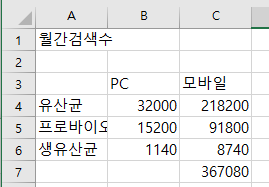

- 프로바이오틱스의 2021-03-10 ~ 2021-04-10 (1개월)의 상댓값의 총합은 162.5559 이며, 
- 검색량의 실제 총합은 367080이므로 
- 367080/162.5559를 한 값이 상댓값 1에 해당하는 검색의 절대량
(스케일링을 위한 값 하나만 있으면 되기 때문에 그냥 엑셀에서 따로 계산...ㅎㅎ)
- scaler = 2258.17661650362

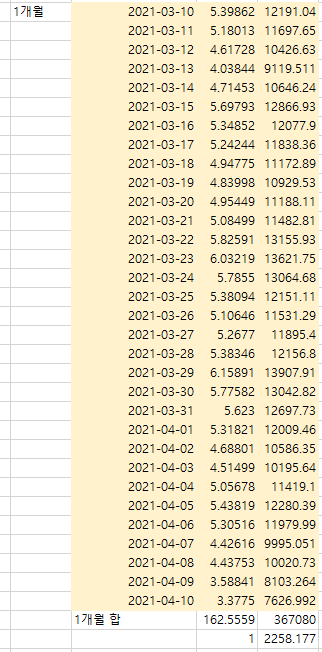

#### 새로운 데이터프레임 만들기
#### 
- df_result에서 날짜 컬럼만 제외하고 일단 가져온다음 
- 스케일러를 곱해 절대 검색량으로 만들어주고
- 그 다음에 날짜 컬럼을 다시 붙였다 

In [6]:
df_realvalue = df_result.iloc[:,1:]
scaler = 2258.17661650362
df_realvalue = round(df_realvalue*scaler, 1)
df_realvalue.insert(0, "date", df_result["date"])

In [7]:
df_realvalue

date  프로바이오틱스  기타다이어트식품   뷰티푸드   헬스보충제     곤약쌀  다이어트차    곤약젤리  \
0     2018-01-01   5651.6     969.6    0.0  2849.1   788.1  766.2  4254.1   
1     2018-01-02   7668.8    1326.1    0.0  4011.7  1033.3  962.0  4842.6   
2     2018-01-03   7928.3    1221.6    0.0  4039.3  1088.5  962.0  4584.0   
3     2018-01-04   7072.8    1144.6    0.0  3977.5   946.8  863.2  4598.3   
4     2018-01-05   8854.3    1000.1    0.0  3349.1   771.0  799.5  4565.0   
...          ...      ...       ...    ...     ...     ...    ...     ...   
1191  2021-04-06  11980.0    1138.9  232.9  8745.9  3051.5  954.4  2157.0   
1192  2021-04-07   9995.1    1107.5  221.5  7922.7  2215.9  808.0  2202.6   
1193  2021-04-08  10020.7    1017.2  197.7  7546.2  2158.9  836.6  2111.4   
1194  2021-04-09   8103.3     889.8  188.2  6191.5  1936.5  643.6  1915.5   
1195  2021-04-10   7627.0     768.1  127.4  6041.3  1707.3  619.8  1812.9   

        식이섬유   가르시니아  ...   헛개나무    건강음료    로얄제리   비타민A    스쿠알렌   건강환/정  \
0      300.4  2524.9  ...  370.7  2066.7  2267.3  385.0   593.2   945.9   
1      512.4  3354.8  ...  342.2  2394.7   886.0  508.6   894.6  1142.7   
2      606.5  3430.9  ...  405.0  2347.1   791.9  540.0  1054.3  1077.1   
3      519.0  3123.8  ...  380.3  2218.8   784.3  513.3   731.0  1034.3   
4      480.1  2517.3  ...  302.3  1835.7   756.7  431.6   809.0   925.9   
...      ...     ...  ...    ...     ...     ...    ...     ...     ...   
1191  1190.2  1483.0  ...  106.5  1522.9  1994.4  672.1   150.2  1408.8   
1192  1081.8  1376.5  ...  103.6  1380.3  1456.4  645.5   178.7  1384.1   
1193  1107.5  1402.2  ...   91.3  1446.9  1060.0  665.4   148.3  1274.8   
1194  1002.9  1147.4  ...   98.9  1090.4  1045.7  704.4   152.1  1205.4   
1195   944.0  1085.6  ...  100.8  1040.0   959.2  574.2   135.9  1128.4   

         석류즙   기타건강즙      꿀   비타민E  
0      478.2   258.6  217.7  378.3  
1      586.5   370.7  235.8  514.3  
2     1213.0   415.4  279.5  530.4  
3      757.6   459.2  302.3  460.1  
4      565.6   413.5  236.7  462.0  
...      ...     ...    ...    ...  
1191  1898.4  2118.0  300.4  613.2  
1192  1950.7  2639.9  291.8  546.6  
1193  1811.0  1505.8  271.9  553.3  
1194  1684.5  1895.6  278.5  584.6  
1195  1507.7  1226.3  231.9  553.3  

[1196 rows x 96 columns]

## 이제 그래프를 그려볼 수 있다
#### 
#### 1. 성분별 검색량
#### 2. 전체 검색량의 추이
#### 3. 전체 검색량에서 개별 카테고리가 차지하는 비중 

### 1. 성분별 검색량
#### 
#### 알아낸 사실
- 몇 가지 성분들에 대해 검색 최대량을 찍은 날에 무슨 일이 있었는지 조사했을 때
- 마케팅이거나 부정적인 이슈인 것을 발견함 
- 건강식품은 마케팅의 영향을 많이 받는다?!
- 이와 관련한 좀더 구체적인 내용은 맨 밑에 참고자료로 첨부함

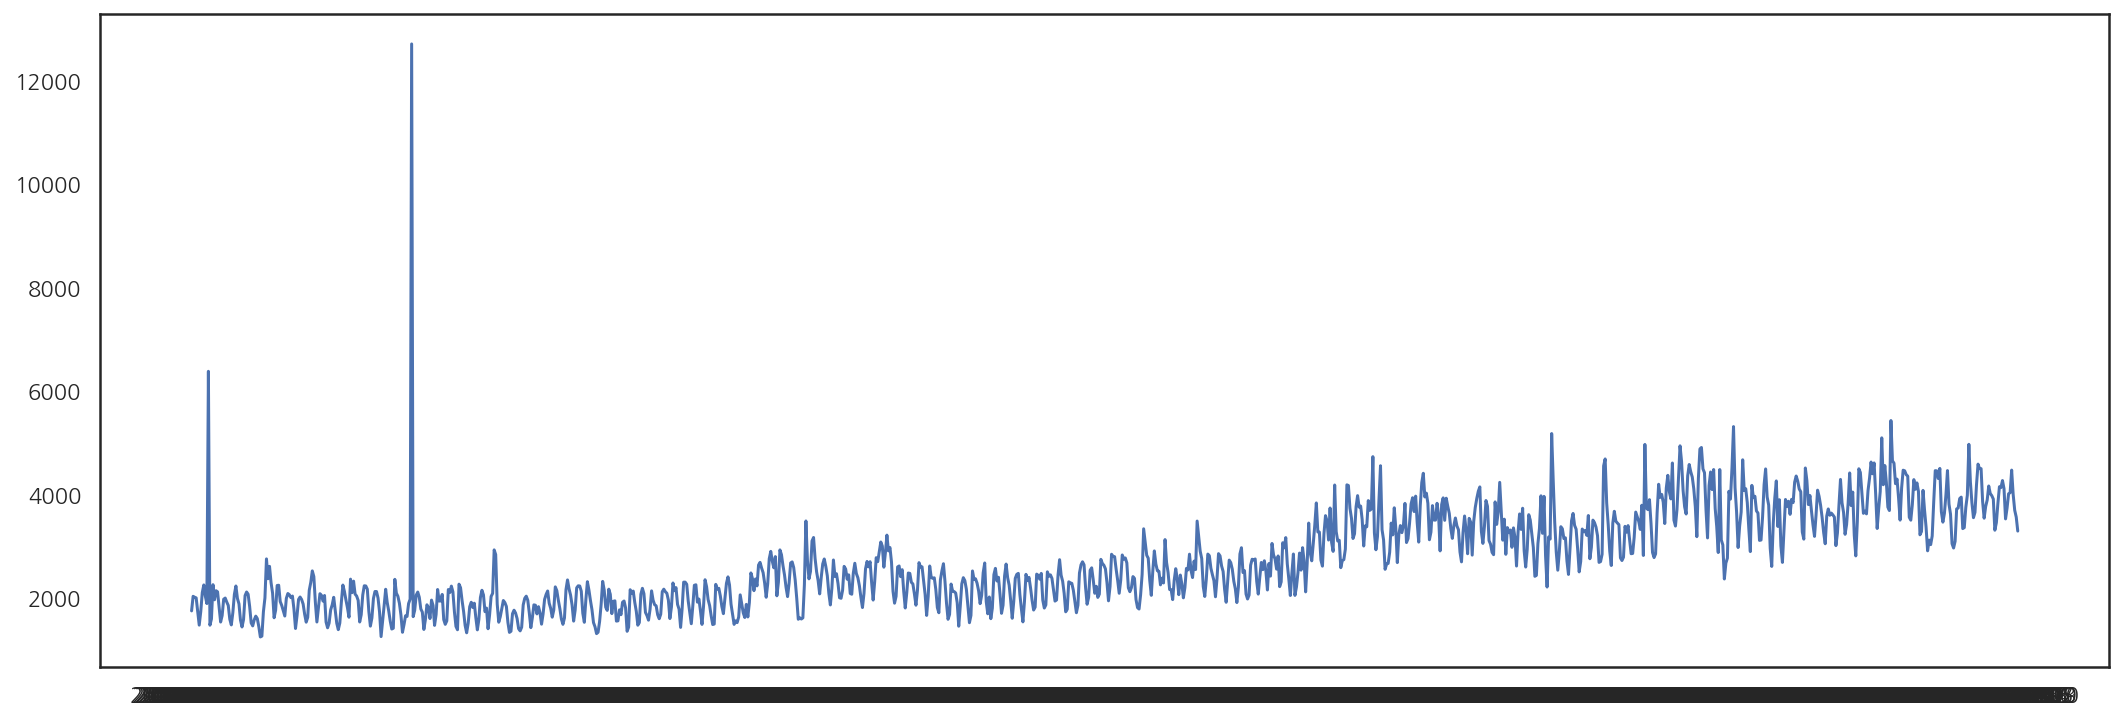

In [8]:
plt.figure(figsize = (18,6))

plt.plot(df_realvalue["date"], df_realvalue["오메가3"])
plt.show()

In [9]:
df_realvalue[df_realvalue["오메가3"] > 5000]

date  프로바이오틱스  기타다이어트식품   뷰티푸드    헬스보충제     곤약쌀  다이어트차    곤약젤리  \
11    2018-01-12   6818.0     932.6    0.0   3063.0   749.1  782.4  5497.6   
144   2018-05-25   7017.6    1870.9   25.7   4910.1  1380.3  853.7  7936.0   
890   2020-06-09  12459.1    1557.1  350.8   8409.4  1420.3  722.5  2200.7   
1009  2020-10-06  12992.4    1168.3  226.2  10295.5  1278.6  697.8  1344.2   
1106  2021-01-11  12922.1    1271.9  181.6   6183.0  1638.9  825.1  1653.2   
1112  2021-01-17  10251.7    1150.3  151.1   6300.9  1408.8  796.6  1727.3   

        식이섬유   가르시니아  ...   헛개나무    건강음료    로얄제리   비타민A   스쿠알렌   건강환/정  \
11     424.0  2289.1  ...  243.4  1542.9   935.4  420.2  983.9   809.0   
144    531.4  1925.1  ...  136.9  6761.0  1123.6  709.2  443.9   649.3   
890   1251.0  2016.3  ...  160.6  2531.6  1649.3  709.2  214.8   923.1   
1009  1091.3  1594.2  ...  185.4  2127.5  1120.8  733.9  270.9  1137.9   
1106   874.6  1426.9  ...  131.2  2036.3  1126.5  655.0  152.1  1304.3   
1112   869.8  1322.3  ...  133.1  1609.4   852.7  639.8  155.9  1382.2   

         석류즙   기타건강즙      꿀    비타민E  
11     540.9   472.5  216.7   557.1  
144    770.0   353.6  741.5   460.1  
890   2106.6   481.0  507.6   682.6  
1009  3526.9   816.6  418.3   623.6  
1106  1656.0   852.7  268.1   623.6  
1112  1360.3  1054.3  264.3  1335.6  

[6 rows x 96 columns]

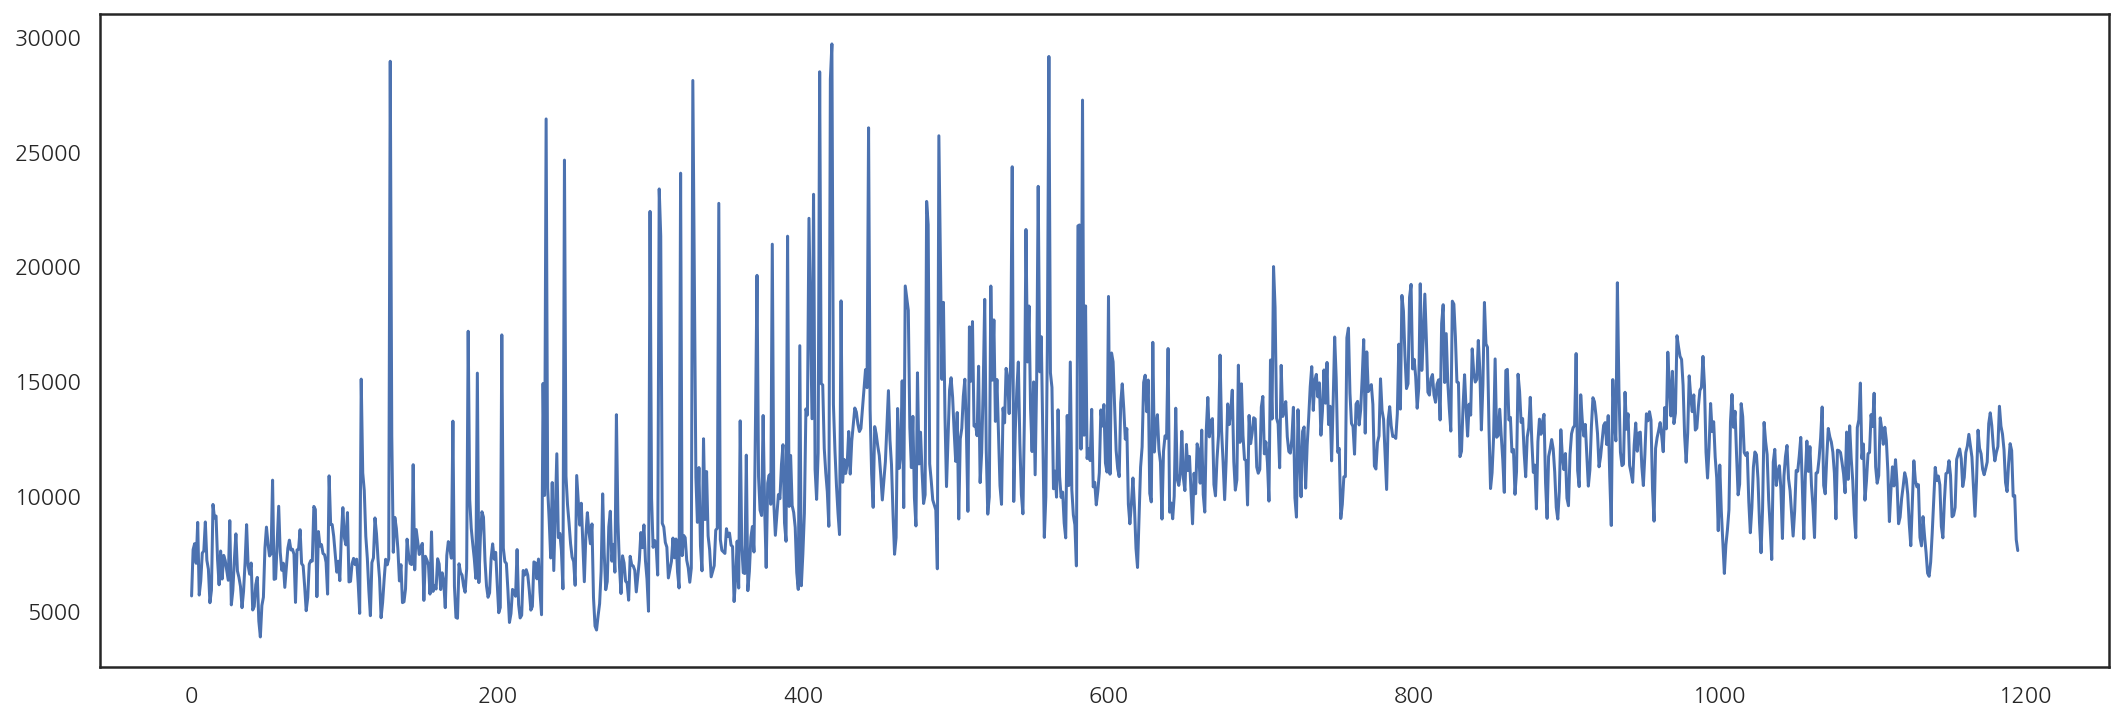

In [10]:
crop_range = df_realvalue[df_realvalue["프로바이오틱스"] < 30000]
crop_range.head()

plt.figure(figsize = (18,6))

plt.plot(list(crop_range.index), crop_range["프로바이오틱스"])
plt.show()

In [11]:
crop_range

date  프로바이오틱스  기타다이어트식품   뷰티푸드   헬스보충제     곤약쌀  다이어트차    곤약젤리  \
0     2018-01-01   5651.6     969.6    0.0  2849.1   788.1  766.2  4254.1   
1     2018-01-02   7668.8    1326.1    0.0  4011.7  1033.3  962.0  4842.6   
2     2018-01-03   7928.3    1221.6    0.0  4039.3  1088.5  962.0  4584.0   
3     2018-01-04   7072.8    1144.6    0.0  3977.5   946.8  863.2  4598.3   
4     2018-01-05   8854.3    1000.1    0.0  3349.1   771.0  799.5  4565.0   
...          ...      ...       ...    ...     ...     ...    ...     ...   
1191  2021-04-06  11980.0    1138.9  232.9  8745.9  3051.5  954.4  2157.0   
1192  2021-04-07   9995.1    1107.5  221.5  7922.7  2215.9  808.0  2202.6   
1193  2021-04-08  10020.7    1017.2  197.7  7546.2  2158.9  836.6  2111.4   
1194  2021-04-09   8103.3     889.8  188.2  6191.5  1936.5  643.6  1915.5   
1195  2021-04-10   7627.0     768.1  127.4  6041.3  1707.3  619.8  1812.9   

        식이섬유   가르시니아  ...   헛개나무    건강음료    로얄제리   비타민A    스쿠알렌   건강환/정  \
0      300.4  2524.9  ...  370.7  2066.7  2267.3  385.0   593.2   945.9   
1      512.4  3354.8  ...  342.2  2394.7   886.0  508.6   894.6  1142.7   
2      606.5  3430.9  ...  405.0  2347.1   791.9  540.0  1054.3  1077.1   
3      519.0  3123.8  ...  380.3  2218.8   784.3  513.3   731.0  1034.3   
4      480.1  2517.3  ...  302.3  1835.7   756.7  431.6   809.0   925.9   
...      ...     ...  ...    ...     ...     ...    ...     ...     ...   
1191  1190.2  1483.0  ...  106.5  1522.9  1994.4  672.1   150.2  1408.8   
1192  1081.8  1376.5  ...  103.6  1380.3  1456.4  645.5   178.7  1384.1   
1193  1107.5  1402.2  ...   91.3  1446.9  1060.0  665.4   148.3  1274.8   
1194  1002.9  1147.4  ...   98.9  1090.4  1045.7  704.4   152.1  1205.4   
1195   944.0  1085.6  ...  100.8  1040.0   959.2  574.2   135.9  1128.4   

         석류즙   기타건강즙      꿀   비타민E  
0      478.2   258.6  217.7  378.3  
1      586.5   370.7  235.8  514.3  
2     1213.0   415.4  279.5  530.4  
3      757.6   459.2  302.3  460.1  
4      565.6   413.5  236.7  462.0  
...      ...     ...    ...    ...  
1191  1898.4  2118.0  300.4  613.2  
1192  1950.7  2639.9  291.8  546.6  
1193  1811.0  1505.8  271.9  553.3  
1194  1684.5  1895.6  278.5  584.6  
1195  1507.7  1226.3  231.9  553.3  

[1181 rows x 96 columns]

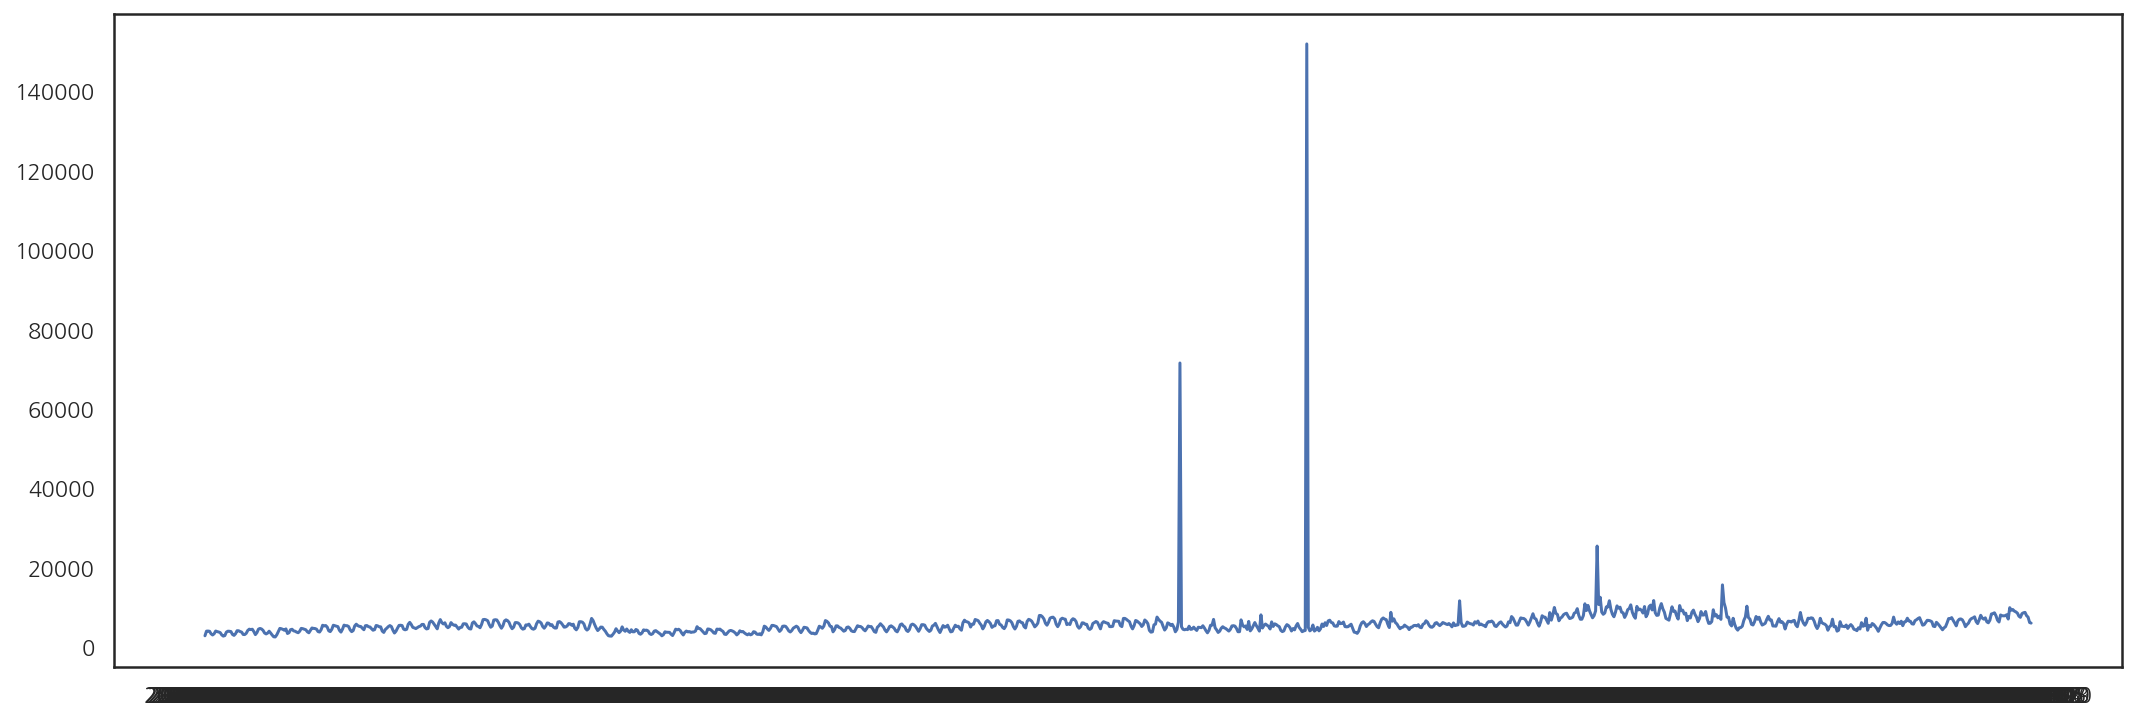

In [12]:
plt.figure(figsize = (18,6))

plt.plot(df_realvalue["date"], df_realvalue["헬스보충제"])
plt.show()

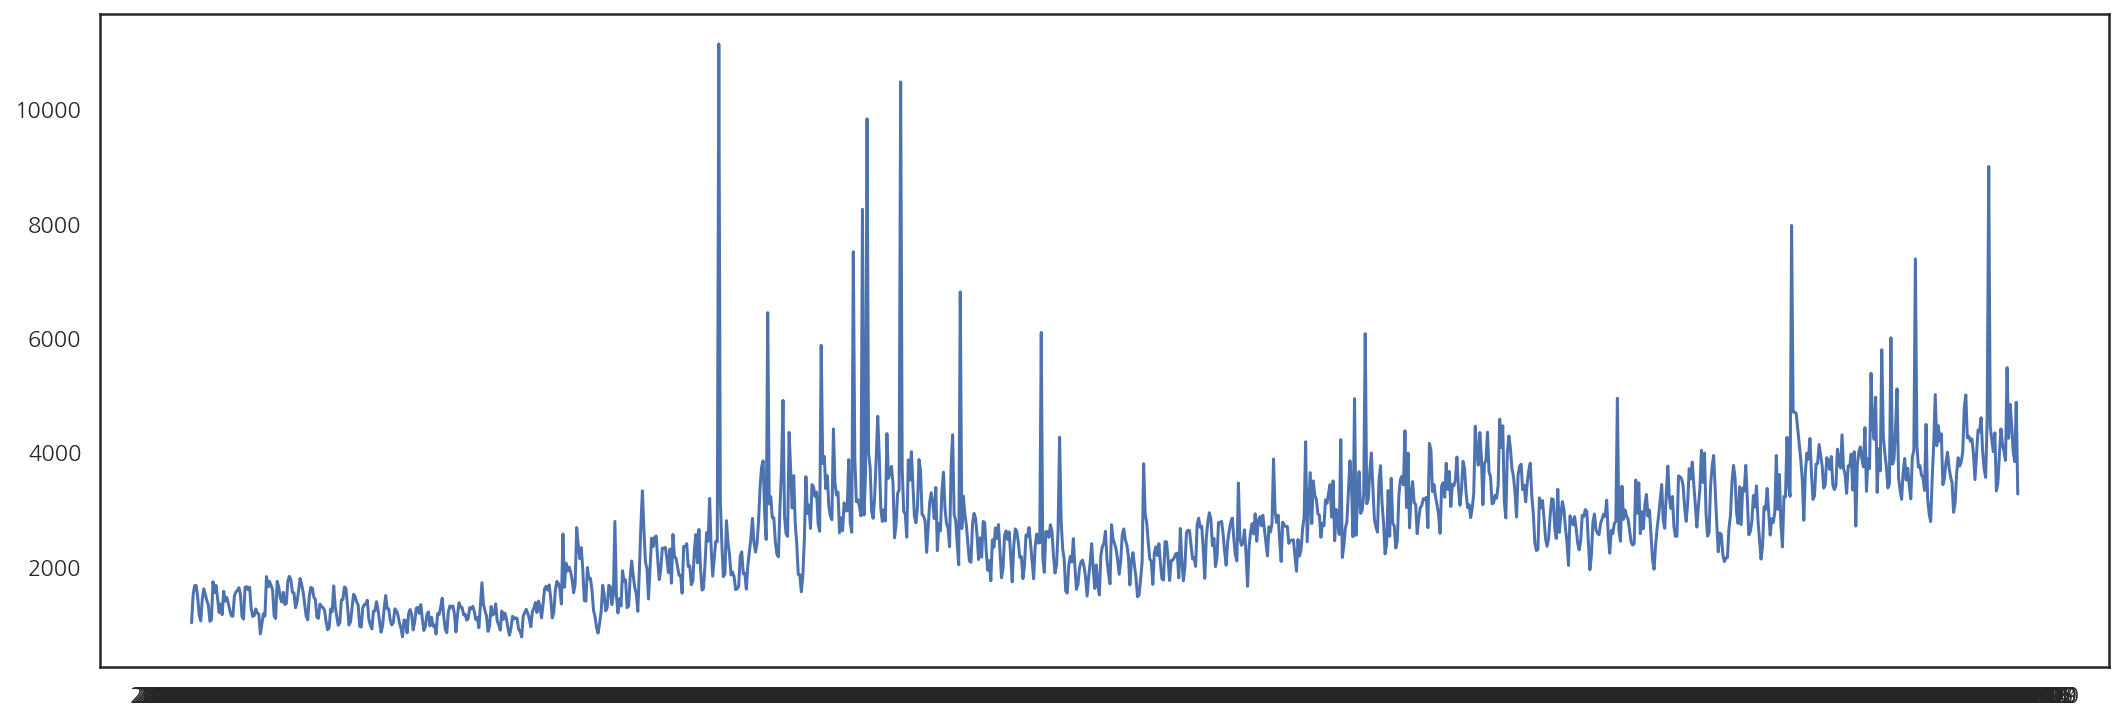

In [14]:
plt.figure(figsize = (18,6))

plt.plot(df_realvalue["date"], df_realvalue["루테인"])
plt.show()

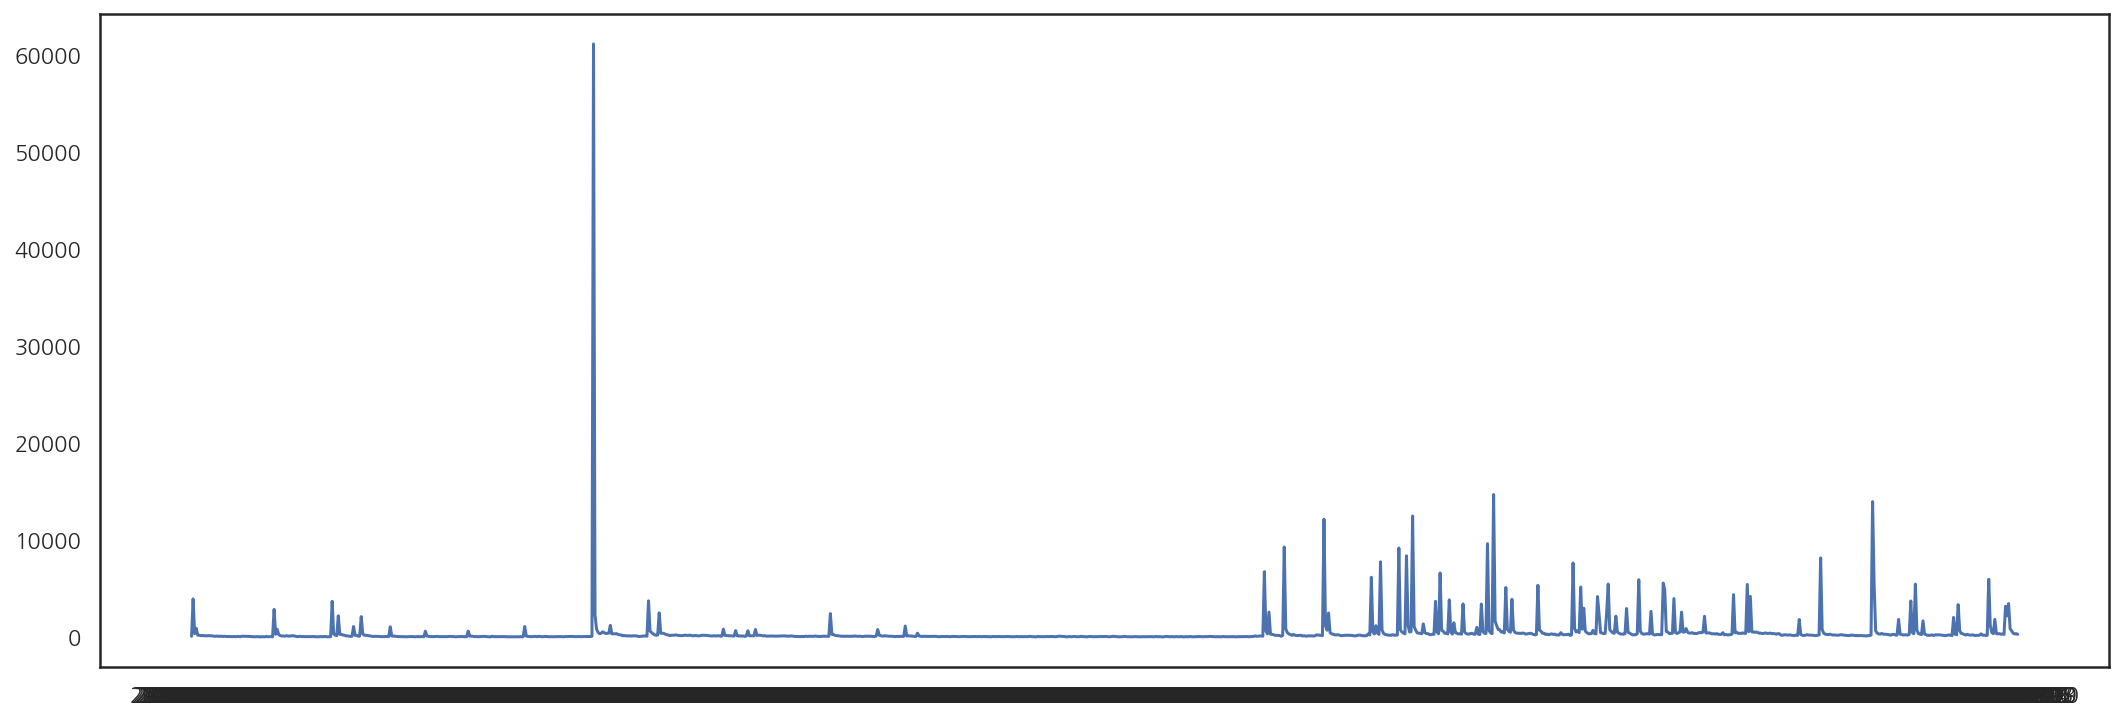

In [15]:
plt.figure(figsize = (18,6))

plt.plot(df_realvalue["date"], df_realvalue["양태반"])
plt.show()

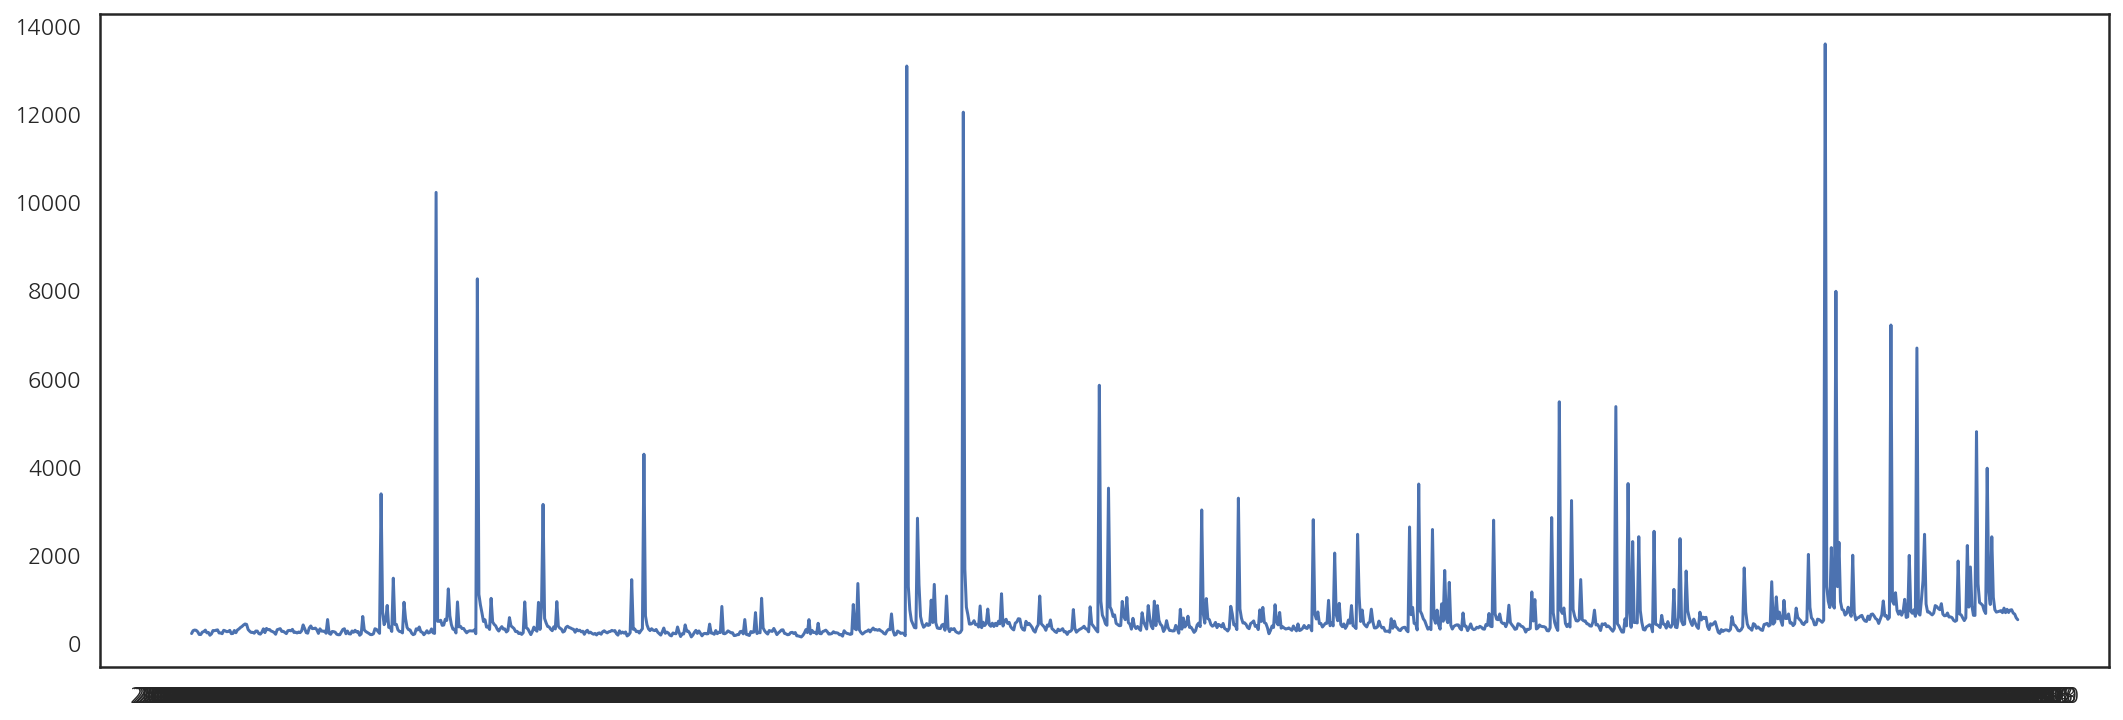

In [17]:
plt.figure(figsize = (18,6))

plt.plot(df_realvalue["date"], df_realvalue["초록입홍합"])
plt.show()

In [18]:
df_realvalue[df_realvalue["초록입홍합"] > 10000]

date  프로바이오틱스  기타다이어트식품   뷰티푸드   헬스보충제     곤약쌀  다이어트차    곤약젤리  \
160   2018-06-10   5953.9    1469.7  100.8  5179.1  4296.0  736.7  6869.3   
468   2019-04-14  37019.0    1133.2  210.1  4662.9  1133.2  735.8  4005.1   
505   2019-05-21  14337.6    1167.4  209.1  6816.1   806.1  865.1  3665.7   
1069  2020-12-05  10097.7     534.2  127.4  4251.3   795.7  463.9  1008.6   

        식이섬유   가르시니아  ...   헛개나무    건강음료    로얄제리   비타민A   스쿠알렌  건강환/정     석류즙  \
160    523.8  2108.5  ...  111.2  2333.8  1279.6  625.5  289.0  692.1   559.9   
468    809.9  3135.2  ...  138.8  2510.6  1638.9  674.0  149.2  650.2   990.5   
505   1038.1  1625.6  ...  110.3  2361.4  2082.9  695.9  203.4  774.8  1028.6   
1069   701.6  1056.1  ...  139.7  1338.5  1079.9  632.2  171.1  916.4  1628.4   

       기타건강즙      꿀   비타민E  
160    563.7  736.7  460.1  
468    299.4  307.0  482.9  
505    308.9  711.1  648.3  
1069  1727.3  296.6  589.4  

[4 rows x 96 columns]

### 2. 전체 검색량 트렌드 

#### 알아낸 사실
- 전반적으로 검색량이 증가하고 있다고는 볼 수 있다 
- 2019년 상반기, 그다음 하반기에는 유난히 검색량이 폭등하는 때가 있었다. 이 때 방송광고가 활발하게 이루어졌던 것이 아닌지 의심해볼 수 있다 

In [19]:
#열 기준 총합 계산
df_realvalue["sum"] = df_realvalue.sum(axis = 1)

In [20]:
df_realvalue["sum"]

0        72611.9
1        96123.2
2        96113.2
3        94382.8
4        91795.2
          ...   
1191    186297.6
1192    164550.1
1193    161351.5
1194    151794.9
1195    130508.8
Name: sum, Length: 1196, dtype: float64

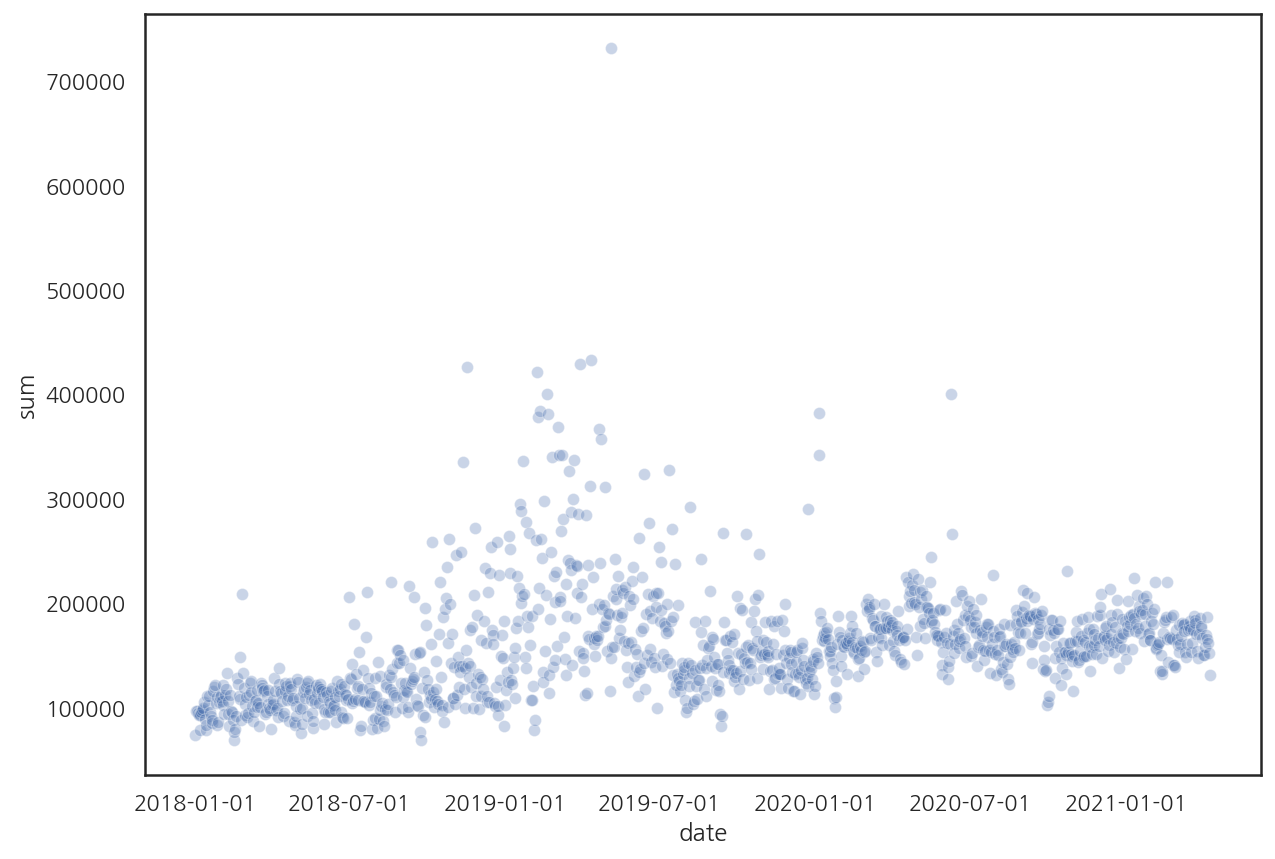

In [29]:
plt.figure(figsize = (10,7))
sns.scatterplot(x= "date", y = "sum", alpha=.3, data=df_realvalue)
#투명도를 설정해서 밀집도를 대략적으로 판단할 수 있다 !
plt.xticks(["2018-01-01", "2018-07-01","2019-01-01", "2019-07-01","2020-01-01","2020-07-01", "2021-01-01"])
plt.show()

### 3. 전체 검색량에서 개별 카테고리가 차지하는 비중
- 각 카테고리별(=컬럼별) 합계 계산
- 각 카테고리별 합계 / 전체 총합 으로 비중 계산
#### 

#### 알아낸 사실
- 검색량과 시장 점유율, 혹은 인기 카테고리가 다르다 !!!
- 프로바이오틱스는 여전히 1등이지만, 의외로 건강분말, 밀크씨슬 등이 상위권에 랭크되어있다 
- 성분별 검색량을 그려보면 아웃라이어들이 발견되는데, 아웃라이어의 영향으로 보인다  

In [22]:
#일단 날짜는 인덱스로 사용한다 
cate_sum = df_realvalue.set_index("date")
cate_sum

프로바이오틱스  기타다이어트식품   뷰티푸드   헬스보충제     곤약쌀  다이어트차    곤약젤리    식이섬유  \
date                                                                          
2018-01-01   5651.6     969.6    0.0  2849.1   788.1  766.2  4254.1   300.4   
2018-01-02   7668.8    1326.1    0.0  4011.7  1033.3  962.0  4842.6   512.4   
2018-01-03   7928.3    1221.6    0.0  4039.3  1088.5  962.0  4584.0   606.5   
2018-01-04   7072.8    1144.6    0.0  3977.5   946.8  863.2  4598.3   519.0   
2018-01-05   8854.3    1000.1    0.0  3349.1   771.0  799.5  4565.0   480.1   
...             ...       ...    ...     ...     ...    ...     ...     ...   
2021-04-06  11980.0    1138.9  232.9  8745.9  3051.5  954.4  2157.0  1190.2   
2021-04-07   9995.1    1107.5  221.5  7922.7  2215.9  808.0  2202.6  1081.8   
2021-04-08  10020.7    1017.2  197.7  7546.2  2158.9  836.6  2111.4  1107.5   
2021-04-09   8103.3     889.8  188.2  6191.5  1936.5  643.6  1915.5  1002.9   
2021-04-10   7627.0     768.1  127.4  6041.3  1707.3  619.8  1812.9   944.0   

             가르시니아  기타곤약가공품  ...    건강음료    로얄제리   비타민A    스쿠알렌   건강환/정  \
date                         ...                                          
2018-01-01  2524.9    107.2  ...  2066.7  2267.3  385.0   593.2   945.9   
2018-01-02  3354.8    182.0  ...  2394.7   886.0  508.6   894.6  1142.7   
2018-01-03  3430.9    218.5  ...  2347.1   791.9  540.0  1054.3  1077.1   
2018-01-04  3123.8    158.7  ...  2218.8   784.3  513.3   731.0  1034.3   
2018-01-05  2517.3    150.4  ...  1835.7   756.7  431.6   809.0   925.9   
...            ...      ...  ...     ...     ...    ...     ...     ...   
2021-04-06  1483.0   2430.5  ...  1522.9  1994.4  672.1   150.2  1408.8   
2021-04-07  1376.5   2247.8  ...  1380.3  1456.4  645.5   178.7  1384.1   
2021-04-08  1402.2   2189.4  ...  1446.9  1060.0  665.4   148.3  1274.8   
2021-04-09  1147.4   1946.2  ...  1090.4  1045.7  704.4   152.1  1205.4   
2021-04-10  1085.6   1686.5  ...  1040.0   959.2  574.2   135.9  1128.4   

               석류즙   기타건강즙      꿀   비타민E       sum  
date                                                
2018-01-01   478.2   258.6  217.7  378.3   72611.9  
2018-01-02   586.5   370.7  235.8  514.3   96123.2  
2018-01-03  1213.0   415.4  279.5  530.4   96113.2  
2018-01-04   757.6   459.2  302.3  460.1   94382.8  
2018-01-05   565.6   413.5  236.7  462.0   91795.2  
...            ...     ...    ...    ...       ...  
2021-04-06  1898.4  2118.0  300.4  613.2  186297.6  
2021-04-07  1950.7  2639.9  291.8  546.6  164550.1  
2021-04-08  1811.0  1505.8  271.9  553.3  161351.5  
2021-04-09  1684.5  1895.6  278.5  584.6  151794.9  
2021-04-10  1507.7  1226.3  231.9  553.3  130508.8  

[1196 rows x 96 columns]

In [23]:
#컬럼별 총합 구하기 
sum_table = pd.DataFrame(df_realvalue.sum(axis = 0))
sum_table = sum_table.drop(["date"])
sum_table.columns = ['sum']
sum_table.astype( "float")

sum
프로바이오틱스    14077456.8
기타다이어트식품    1353157.8
뷰티푸드         220105.1
헬스보충제       6993498.2
곤약쌀         1641488.0
...               ...
석류즙         2294274.2
기타건강즙        638595.4
꿀            480591.4
비타민E         692222.0
sum       188916231.6

[96 rows x 1 columns]

In [24]:
#퍼센트 계산 
sum_table["percentage"] = sum_table["sum"] * 100 / 188916231.6

In [25]:
sum_table = sum_table.sort_values(by = "percentage", ascending = False)


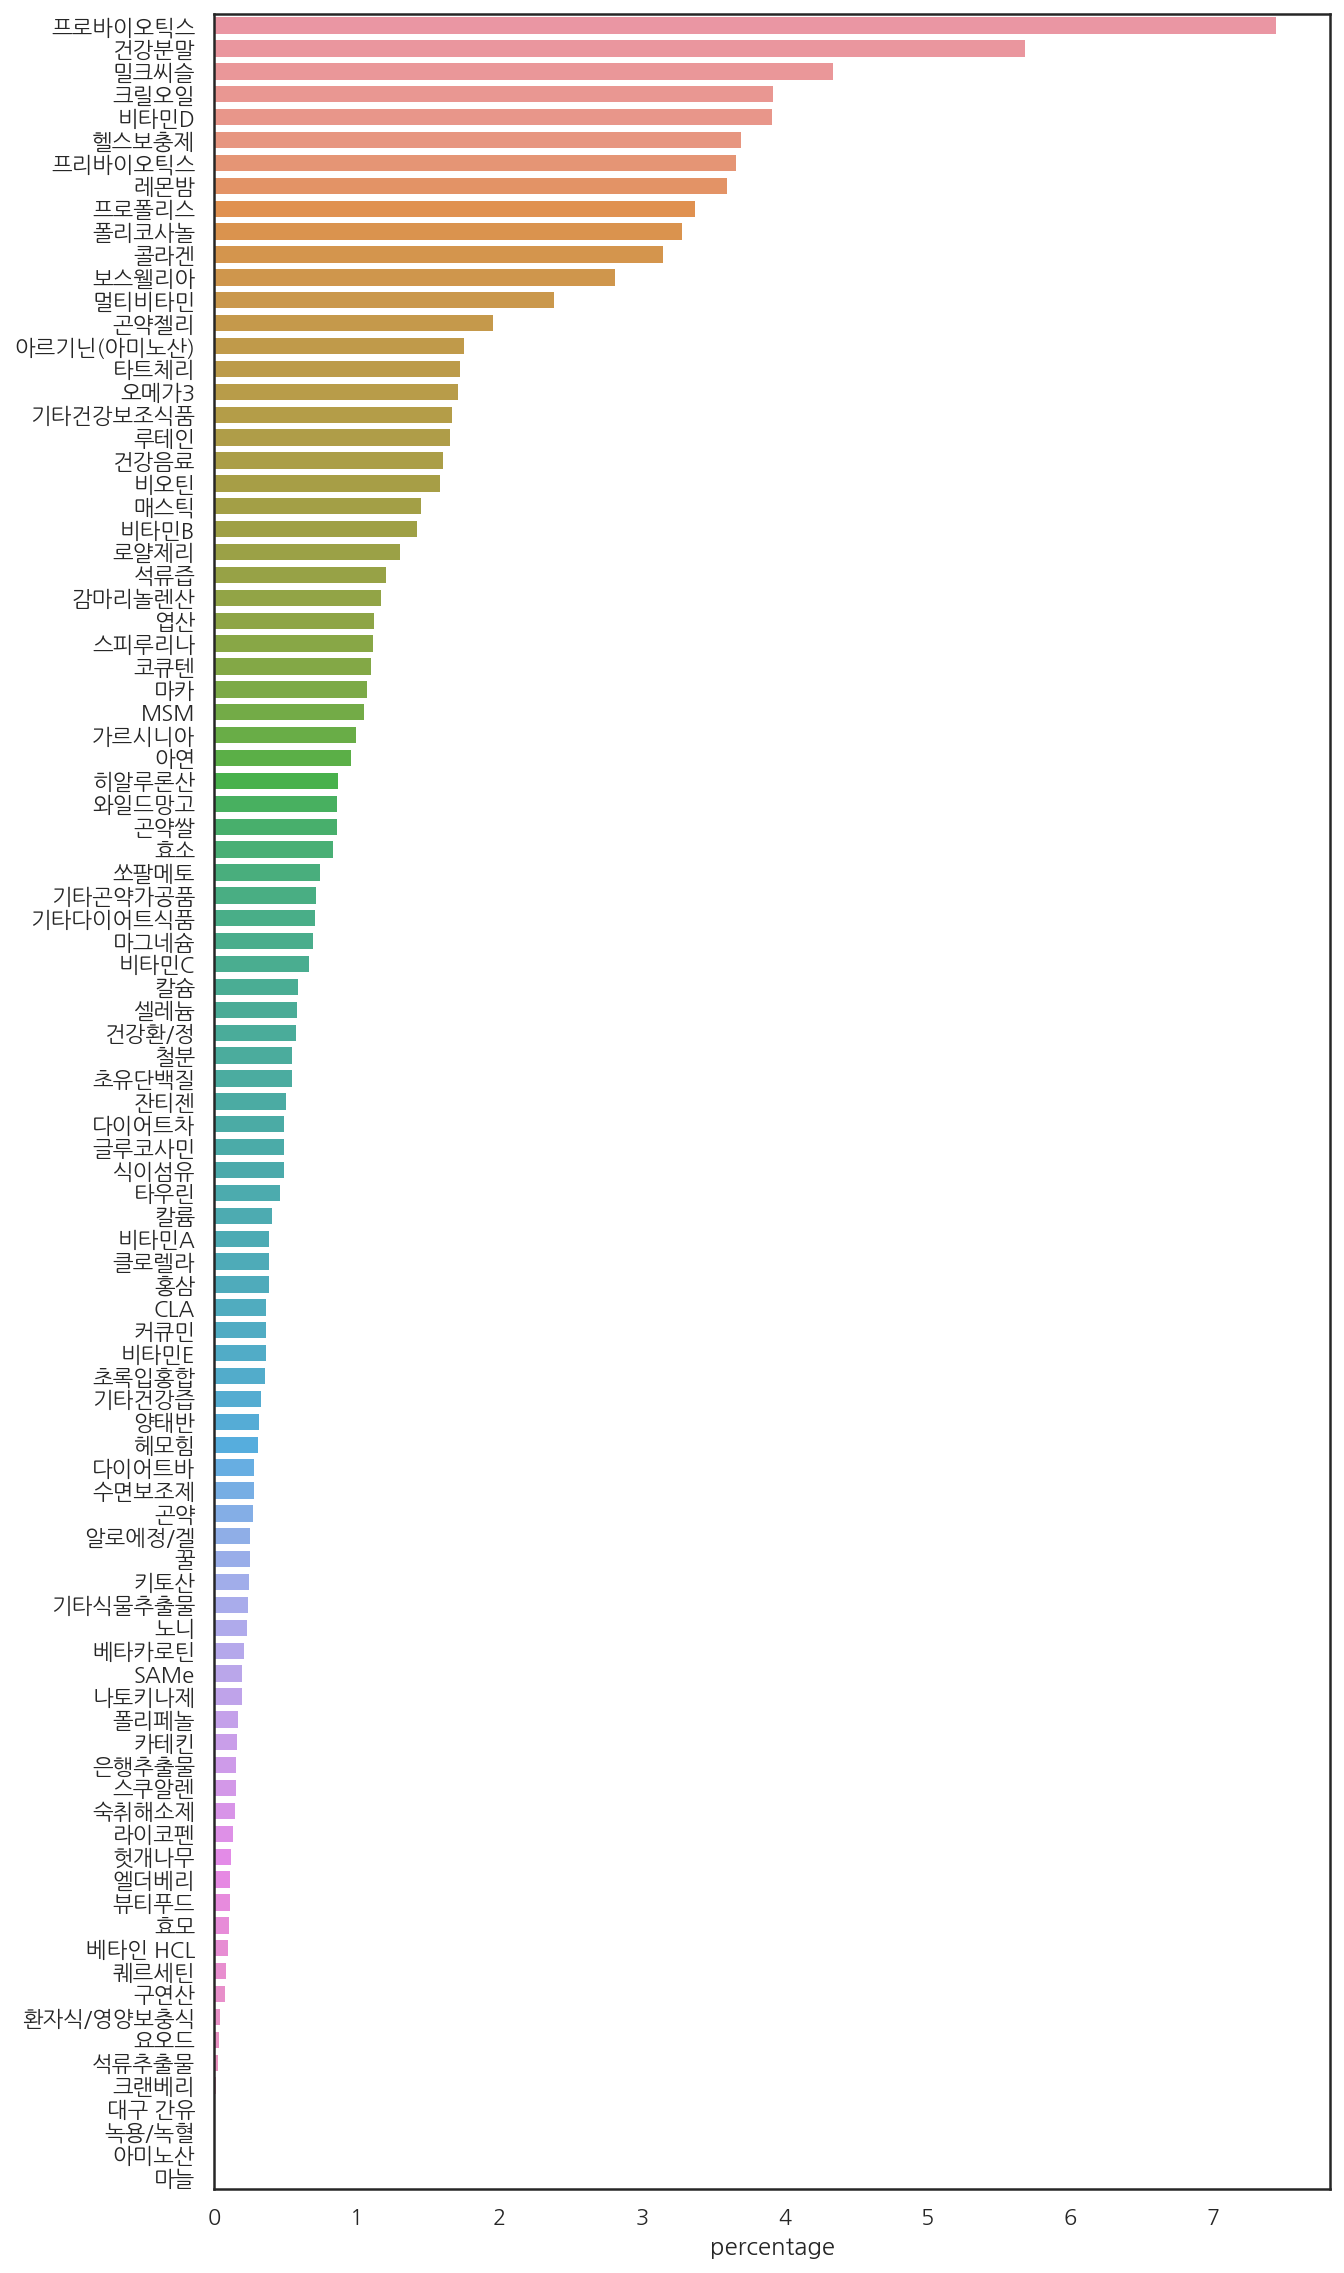

In [26]:
#그래프 그리기 - sum 은 100이므로 제외하고 사용 

new_table = sum_table.drop("sum", axis = 0)

fig = plt.figure(figsize=(10, 20))

sns.barplot(x="percentage", y=list(new_table.index), data = new_table )
ypos = np.arange(len(new_table))
plt.yticks(ypos, list(new_table.index))
plt.show()

### 참고자료 / 아웃라이어가 발생했던 날 있었던 일은?



### 오메가 3

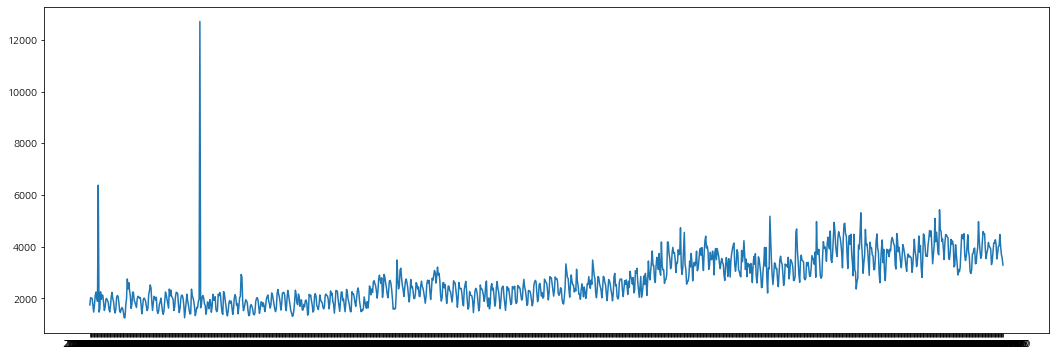

- 2018년 5월 25일에 검색량 최대치 기록
- 관련 이슈 
     - 1) 배우 이호원(인피니트 호야)이 라디오스타에서 오메가3, 비타민C, 프로폴리스 언급 
     http://www.topstarnews.net/news/articleView.html?idxno=417586
     - 2) 배우 김소연이 운동은 안하는데(...) 오메가3를 먹는다고 발언
     http://www.newsworks.co.kr/news/articleView.html?idxno=189197
     - 3) KBS 무엇이든 물어보세요에 24일 방송됨
     http://www.sommeliertimes.com/news/articleView.html?idxno=8807
 

### 단백질 보충제(헬스 보충제)
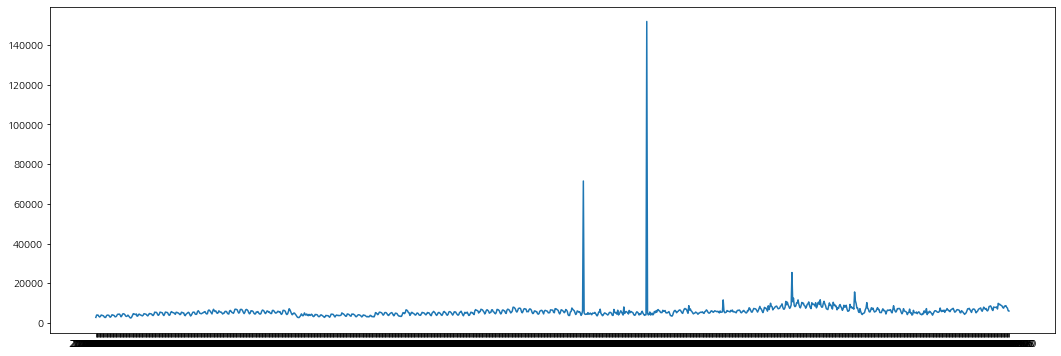

- 2019년 12월 23일, 그 다음으로 2019년 10월 1일에 검색량 최대치 기록
- 관련 이슈
    - 1) 2019년 10월 1일 : 식약처 단백질 보충제 244개 조사 -> 불법 스테로이드 발견 + 거짓, 과장광고 적발 
     https://biz.sbs.co.kr/article/10000956939?division=NAVER
    - 2) 2019년 12월 23일 : 해외직구 단백질 보충제에서 부적합 스테로이드 성분 검출, 통관 차단 요청
     https://biz.chosun.com/site/data/html_dir/2019/12/23/2019122300967.html?utm_source=naver&utm_medium=original&utm_campaign=biz

### 프로바이오틱스
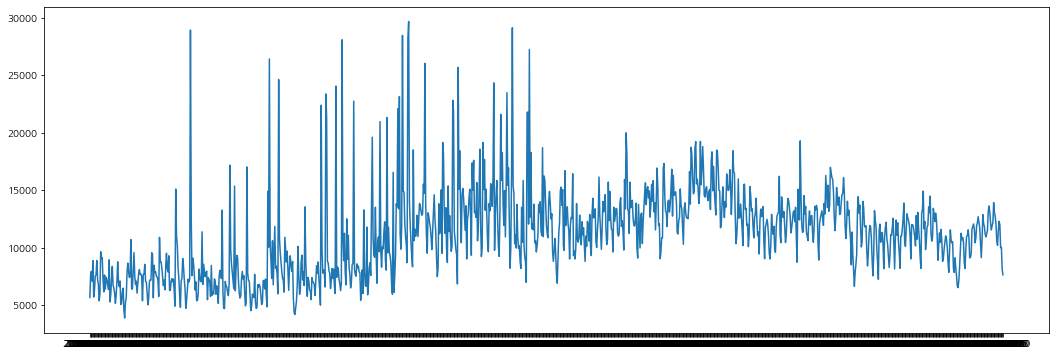

- 프로바이오틱스는 인기 상품이라 자주 방송되는 것 같은데, 일단 검색량 최대치인 날은 2019년 5월 6일
- 관련 이슈
    - 1) SBS 스페셜에서 프리바이오틱스, 프로바이오틱스 방송 
    - 이 시기에 프리바이오틱스도 함께 검색량 증가 
    http://daily.hankooki.com/lpage/entv/201905/dh20190506005531139030.htm

### 양태반
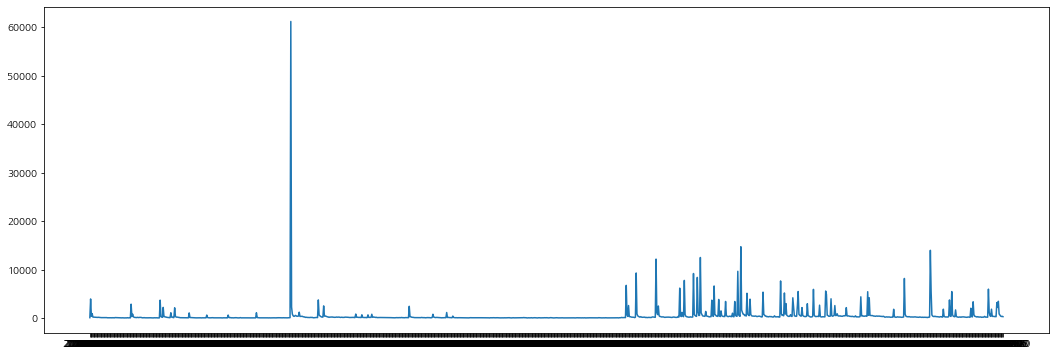
- 2018년 9월 21일에 검색량 최대치 기록 
- 관련 이슈
    - 1) 내 몸 사용 설명서 219회에서 회춘 비결로 등장
    https://cratos112.com/546


### 초록입홍합
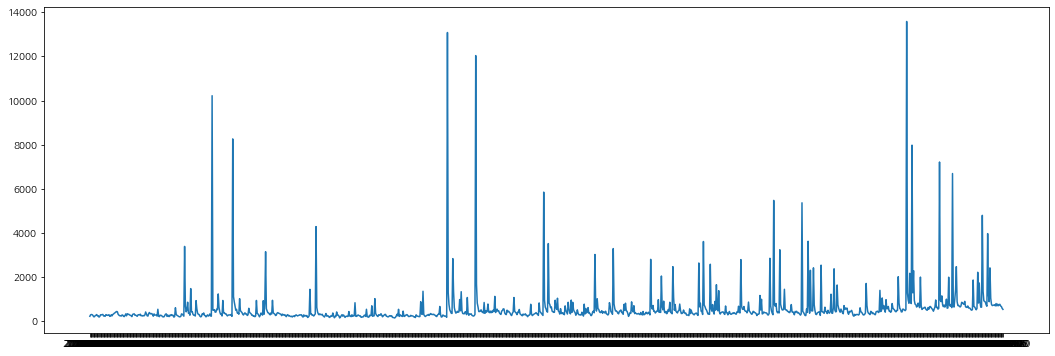

- 2020년 12월 5일에 검색량 최대치 기록
- 관련 이슈
    - 1) 12월 초 "개는 훌륭하다" 방송에 강아지 영양식으로 초록입홍합 성분을 포함한 영양식 등장
    - 2) 이 때 관련 기사, 블로그 체험단 리뷰가 같이 증가했으며 
    - 3) 해당 브랜드에서는 할인이벤트도 함께 진행함 
    https://www.news1.kr/articles/?4135799
    - 4) 참고로 2021 1월에도 방송 출연 + 홍보 진행함. 그래서 검색량이 떨어지지 않고 이어지는 것으로 볼 수 있음
    http://www.youngnong.co.kr/news/articleView.html?idxno=32858

In [30]:
df_diets = df_realvalue[["date", "가르시니아", "기타다이어트식품", "다이어트차"]]

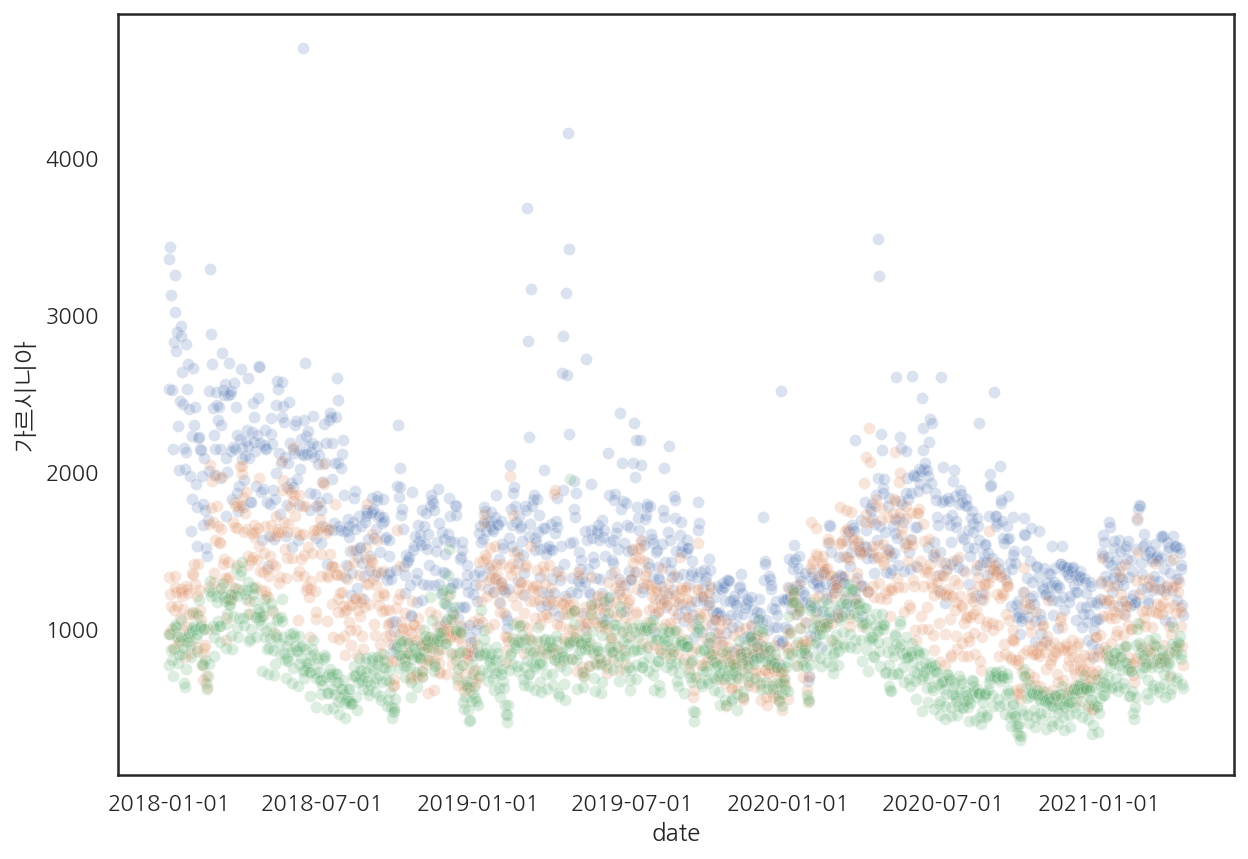

In [35]:
plt.figure(figsize = (10,7))
sns.scatterplot(x= "date", y = "가르시니아", alpha=.2, data=df_diets)
sns.scatterplot(x= "date", y = "기타다이어트식품", alpha=.2, data=df_diets)
sns.scatterplot(x= "date", y = "다이어트차", alpha=.2, data=df_diets)

plt.xticks(["2018-01-01", "2018-07-01","2019-01-01", "2019-07-01","2020-01-01","2020-07-01", "2021-01-01"])
plt.show()

In [36]:
df_dietfoods = df_realvalue[["date", "기타곤약가공품", "다이어트바"]]

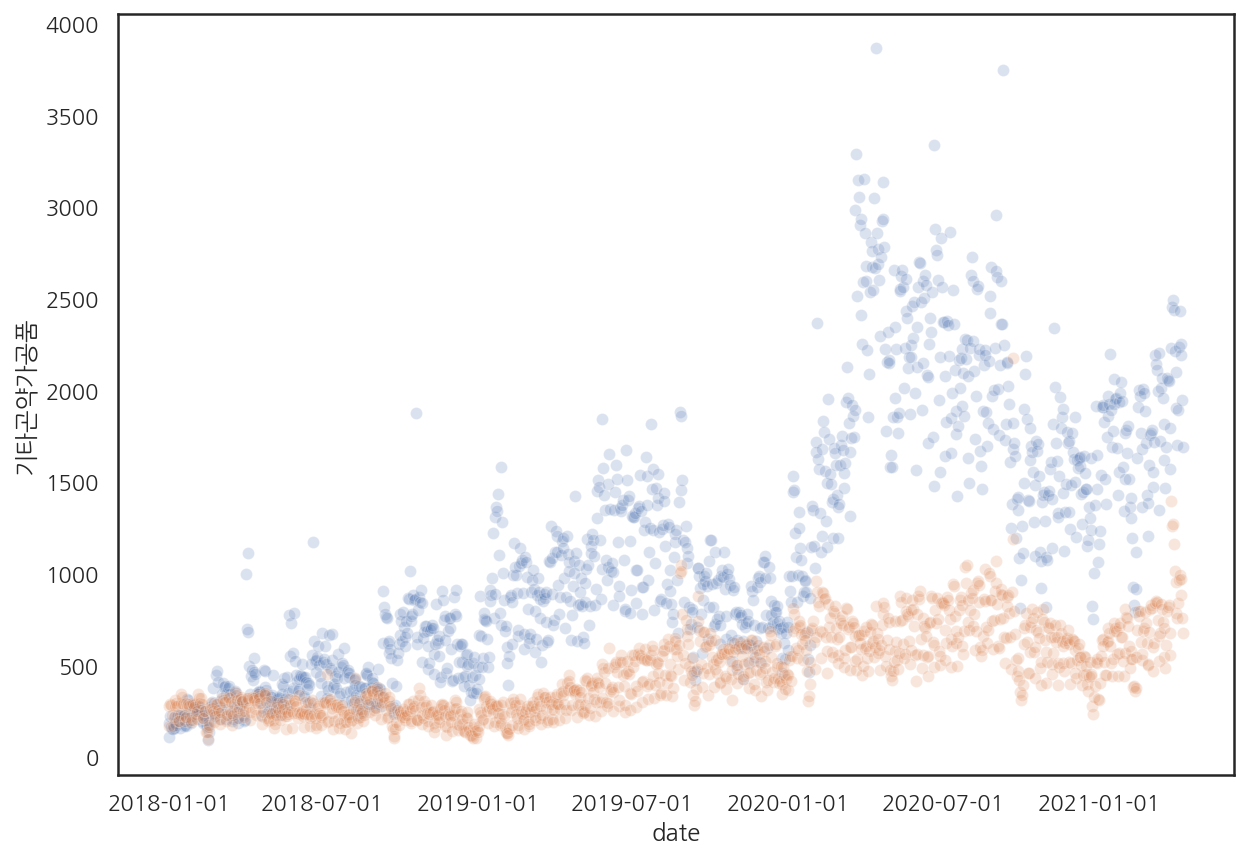

In [38]:
plt.figure(figsize = (10,7))
sns.scatterplot(x= "date", y = "기타곤약가공품", alpha=.2, data=df_dietfoods)
sns.scatterplot(x= "date", y = "다이어트바", alpha=.2, data=df_dietfoods)

plt.xticks(["2018-01-01", "2018-07-01","2019-01-01", "2019-07-01","2020-01-01","2020-07-01", "2021-01-01"])
plt.show()

#### API 파라미터값 참고
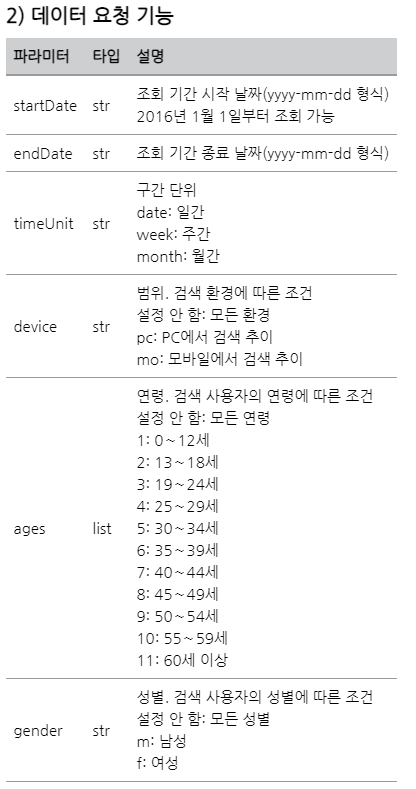